Imports

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import folium

Mesh building function definition

In [9]:
def build_mesh(shape_filepath, grid_resolution=1000):
    """
    Builds a spatial mesh of nodes (centroids of grid cells) within the input catchment boundary.

    Args:
        shape_filepath (str): Path to the catchment boundary shapefile.
        grid_resolution (int): Resolution of the grid (default 1 km resolution, EPSG:27700 is in meters).

    Returns:
        tuple: (mesh_nodes_table_df, mesh_nodes_gdf)
            - mesh_nodes_table_df (pd.DataFrame): Node ID and coordinates.
            - mesh_nodes_gdf (gpd.GeoDataFrame): Node ID, coordinates, and geometry (Point).
    """
    # Load spatial boundary shape file
    catchment_polygon = gpd.read_file(shape_filepath)
    catchment_polygon = catchment_polygon.to_crs(epsg=27700) # Convert to British National Grid

    # Check polygon geometry -> if shapefile has multiple features then dissolve them
    if len(catchment_polygon) > 1:
        print("\nMultiple polygons found in the catchment boundary. Merging into a single geometry.")
        catchment_geometry = catchment_polygon.unary_union
    else:
        print("\nSingle polygon found in the catchment boundary.")
        catchment_geometry = catchment_polygon.geometry.iloc[0]

    # Get the bounds of the catchment and set grid resolution (in km)
    minx, miny, maxx, maxy = catchment_polygon.total_bounds
    print(f"Catchment bounding box: min_x={minx}, min_y={miny}, max_x={maxx}, max_y={maxy}")

    # Generate bottom left coordinates of grid cells
    x_coordinates_bottomleft = np.arange(minx, maxx + grid_resolution, grid_resolution)
    y_coordinates_bottomleft = np.arange(miny, maxy + grid_resolution, grid_resolution)

    print(f"\nNumber of x-coordinates (bottom-left): {len(x_coordinates_bottomleft)}")
    print(f"Number of y-coordinates (bottom-left): {len(y_coordinates_bottomleft)}")

    # Initialise grid cell list and set up regular grid of points within the bounding box
    grid_cells = []
    for x in x_coordinates_bottomleft:
        for y in y_coordinates_bottomleft:
            cell = box(x, y, x + grid_resolution, y + grid_resolution)
            grid_cells.append(cell)

    print(f"\nGenerated {len(grid_cells)} grid cells within bounding box (before filtering).")

    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:27700")

    # Keep only grid cells that intersect the catchment
    grid_intersected = gpd.overlay(grid_gdf, gpd.GeoDataFrame(geometry=[catchment_geometry], crs="EPSG:27700"), how='intersection', keep_geom_type=True)
    mesh_nodes_gdf = grid_intersected.copy() # Make copy to avoid SettingWithCopyWarning
    print(f"Filtered down to catchment boundary containing {len(grid_intersected)} nodes")

    ## ---- Convert to table ----

    # Calculate the centroid of each (potentially clipped) grid cell
    mesh_nodes_gdf['geometry'] = mesh_nodes_gdf.geometry.representative_point() # previously as .centroid

    # Add original Easting/Northing coordinates (as in EPSG:27700)
    mesh_nodes_gdf['easting'] = mesh_nodes_gdf.geometry.x
    mesh_nodes_gdf['northing'] = mesh_nodes_gdf.geometry.y
    mesh_nodes_gdf['node_id'] = range(len(mesh_nodes_gdf)) # UNID

    # Convert to WGS84 (EPSG:4326) to add lat/lon for visualisations
    mesh_nodes_4326 = mesh_nodes_gdf.to_crs(epsg=4326)
    mesh_nodes_gdf['lon'] = mesh_nodes_4326.geometry.x
    mesh_nodes_gdf['lat'] = mesh_nodes_4326.geometry.y

    # Select the columns needed for node table
    mesh_nodes_table = mesh_nodes_gdf[['node_id', 'easting', 'northing', 'lon', 'lat']]
    
    # Save the mesh nodes table and gdf to appropriate files
    mesh_nodes_table.to_csv("data/eden_catchment_mesh_nodes.csv", index=False)
    mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.gpkg", layer='mesh_nodes', driver='GPKG')  # GeoPackage
    # mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.shp", driver='ESRI Shapefile')  # Uncomment to save as Shapefile

    print("\nFirst few mesh nodes (centroids with coordinates):")
    print(mesh_nodes_table.head())
    print(f"\nTotal number of mesh nodes (centroids) for the catchment: {len(mesh_nodes_table)}\n")
    
    return mesh_nodes_table, mesh_nodes_gdf, catchment_polygon

Create mesh using input shape file

In [10]:
# Define spatial boundary shape filepath from https://nrfa.ceh.ac.uk/data/station/spatial_download/76007
shape_filepath = "data/eden_catchment_boundary/NRFA_catchments.shp"
mesh_nodes_table, mesh_nodes_gdf, catchment_polygon = build_mesh(shape_filepath, grid_resolution=1000)


Single polygon found in the catchment boundary.
Catchment bounding box: min_x=326025.0, min_y=495525.0, max_x=388875.0, max_y=581725.0

Number of x-coordinates (bottom-left): 64
Number of y-coordinates (bottom-left): 88

Generated 5632 grid cells within bounding box (before filtering).
Filtered down to catchment boundary containing 2477 nodes

First few mesh nodes (centroids with coordinates):
   node_id   easting  northing       lon        lat
0        0  326800.0  528012.5 -3.135741  54.641893
1        1  326525.0  528925.0 -3.140231  54.650051
2        2  326650.0  529687.5 -3.138486  54.656920
3        3  327000.0  539475.0 -3.135516  54.744910
4        4  326925.0  539712.5 -3.136740  54.747033

Total number of mesh nodes (centroids) for the catchment: 2477



In [21]:
# Create base map centered on mesh
map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]
map = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB positron')

# Add all node centroids as markers or circles
for _, row in mesh_nodes_gdf.iterrows():
    folium.CircleMarker(location=[row['lat'], row['lon']], radius=1, color='#354c7c',
                        fill=True, fill_opacity=0.6).add_to(map)

map  # display


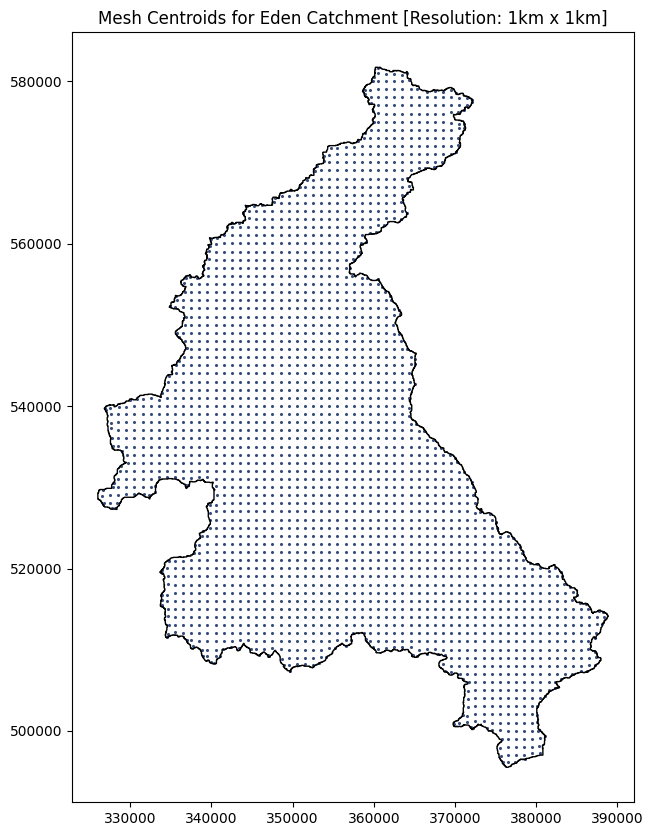

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
mesh_nodes_gdf.plot(ax=ax, color='#354c7c', markersize=1.5)
catchment_polygon.plot(ax=ax, facecolor='none', edgecolor='black')

plt.title("Mesh Centroids for Eden Catchment [Resolution: 1km x 1km]")
plt.show()
